# Sparse Gaussian Process - Classification

In [1]:
import matplotlib as mpl; mpl.use('pgf')

In [2]:
%matplotlib inline

In [3]:
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import defaultdict

from matplotlib import animation
from IPython.display import HTML
from etudes.gaussian_processes import gp_sample_custom, dataframe_from_gp_samples

Instructions for updating:
non-resource variables are not supported in the long term


In [80]:
GOLDEN_RATIO = 0.5 * (1 + np.sqrt(5))
golden_size = lambda width: (width, width / GOLDEN_RATIO)

In [85]:
FIG_WIDTH = 10

rc = {
    "figure.figsize": golden_size(FIG_WIDTH),
#     "font.serif": ['Times New Roman'],
    "text.usetex": True,
}

sns.set(context="talk", style="ticks", palette="colorblind",
        font="serif", rc=rc)

In [86]:
# shortcuts
tfd = tfp.distributions
kernels = tfp.math.psd_kernels

# constants
n_train = 512

n_features = 1 # dimensionality
n_index_points = 256 # nbr of index points

n_samples = 20 # nbr of GP prior samples
jitter = 1e-6
kernel_cls = kernels.MaternFiveHalves

n_inducing_points = 25
n_epochs = 2000
batch_size = 64
quadrature_size = 20

seed = 888 # set random seed for reproducibility
random_state = np.random.RandomState(seed)

x_min, x_max = -1.0, 1.0
y_min, y_max = -6.0, 4.0
x_loc = -0.5
# index points
X_q = np.linspace(-5., 5., n_index_points).reshape(-1, n_features)

In [87]:
p = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.3, 0.7]),
    components_distribution=tfd.Normal(loc=[2.0, -3.0], 
                                       scale=[1.0, 0.5]))
q = tfd.Normal(loc=0.0, scale=2.0)

In [88]:
with tf.Session() as sess:
    q_prob_value, p_prob_value = sess.run([q.prob(X_q), p.prob(X_q)])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


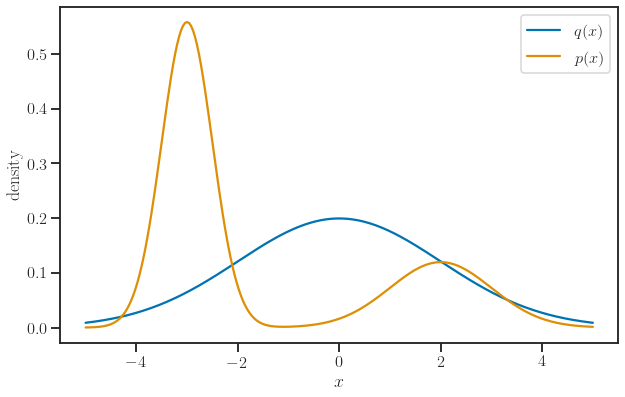

In [89]:
fig, ax = plt.subplots()

ax.plot(X_q, q_prob_value, label='$q(x)$')
ax.plot(X_q, p_prob_value, label='$p(x)$')

ax.set_xlim(-5.5, 5.5)

ax.set_xlabel('$x$')
ax.set_ylabel('density')

ax.legend()

fig.savefig("densities.pgf")
# plt.show()

In [10]:
logit_true = lambda x: p.log_prob(x) - q.log_prob(x)

In [11]:
density_ratio_true = lambda x: tf.exp(logit_true(x))

In [12]:
classifier_true = lambda x: tf.sigmoid(logit_true(x))

In [13]:
with tf.Session() as sess:
    latent_true, density_ratio_value, class_prob_true = sess.run([logit_true(X_q), 
                                                                  density_ratio_true(X_q), 
                                                                  classifier_true(X_q)])

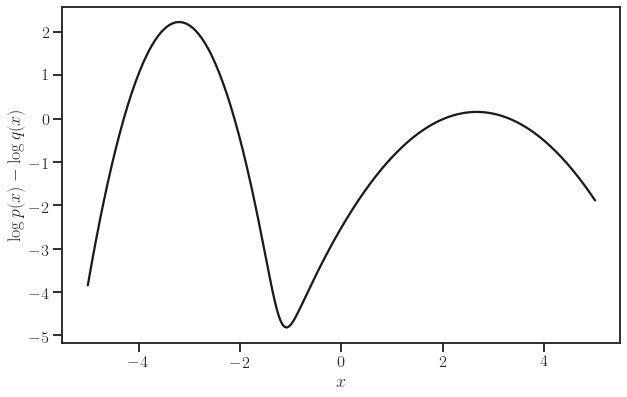

In [92]:
fig, ax = plt.subplots()

ax.plot(X_q, latent_true, 'k-')

ax.set_xlabel('$x$')
ax.set_ylabel(r"$\log p(x) - \log q(x)$")
# ax.legend()

fig.savefig("logits.pgf")
# plt.show()

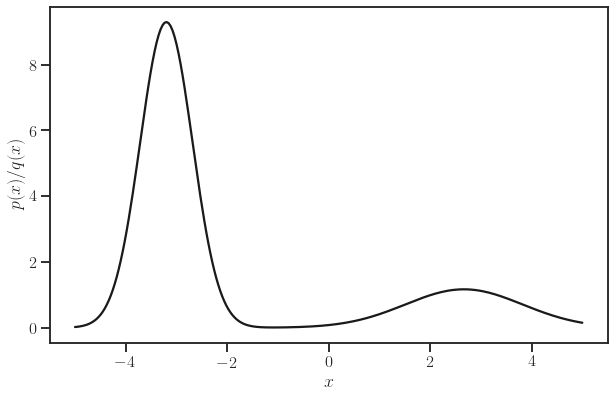

In [94]:
fig, ax = plt.subplots()

ax.plot(X_q, density_ratio_value, 'k-')

ax.set_xlabel('$x$')
ax.set_ylabel(r"$p(x) / q(x)$")
# ax.legend()

fig.savefig("density_ratios.pgf")
# plt.show()

In [16]:
p_samples = p.sample(sample_shape=(n_train // 2, 1), seed=seed)
q_samples = q.sample(sample_shape=(n_train // 2, 1), seed=seed)

In [17]:
X_tensor = tf.concat([p_samples, q_samples], axis=0)
X_tensor

<tf.Tensor 'concat:0' shape=(512, 1) dtype=float32>

In [18]:
Y_tensor = tf.concat([tf.ones_like(p_samples), 
                      tf.zeros_like(q_samples)], axis=0)
Y_tensor

<tf.Tensor 'concat_1:0' shape=(512, 1) dtype=float32>

In [19]:
with tf.Session() as sess:
    X, Y = sess.run([X_tensor, Y_tensor])

In [20]:
X = np.float64(X)
Y = np.float64(Y.squeeze())

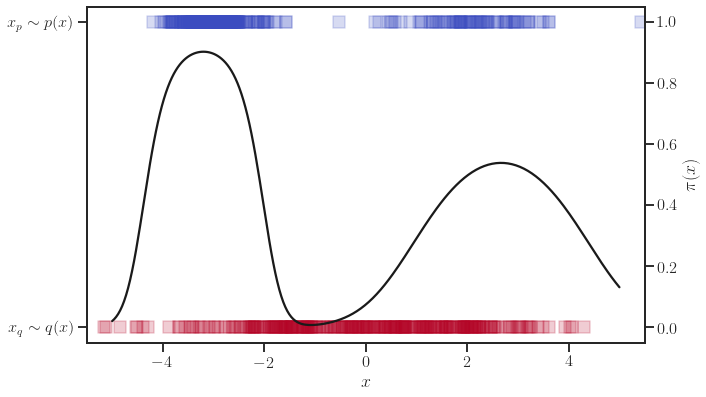

In [90]:
fig, ax1 = plt.subplots()

ax1.scatter(X, Y, c=Y, s=12.**2, 
            marker='s', alpha=.2, cmap='coolwarm_r')

ax1.set_xlabel('$x$')
ax1.set_xlim(-5.5, 5.5)

ax1.set_ylim(-0.05, 1.05)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['$x_q \sim q(x)$', 
                     '$x_p \sim p(x)$'])

ax2 = ax1.twinx()

ax2.plot(X_q, class_prob_true, 'k-')

ax2.set_xlim(-5.5, 5.5)
ax2.set_xlabel('$x$')

ax2.set_ylim(-0.05, 1.05)
# ax2.set_ylabel('$\mathcal{P}(y=1 \mid x)$')
ax2.set_ylabel('$\pi(x)$')

fig.savefig("class_posterior_probabilities.pgf")
# plt.show()

In [22]:
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(-1)), name='length_scale')
observation_noise_variance = tf.exp(tf.Variable(np.float64(-5)), name='observation_noise_variance')
kernel = kernel_cls(amplitude=amplitude, length_scale=length_scale)

In [23]:
inducing_index_points_initial = random_state.choice(X.squeeze(), n_inducing_points).reshape(-1, n_features)
inducing_index_points_initial.shape

(25, 1)

In [24]:
inducing_index_points = tf.Variable(inducing_index_points_initial, 
                                    name='inducing_index_points')
variational_inducing_observations_loc = tf.Variable(np.zeros(n_inducing_points), 
                                                    name='variational_inducing_observations_loc')
variational_inducing_observations_scale = tf.Variable(
    np.eye(n_inducing_points), name='variational_inducing_observations_scale')

In [25]:
vgp = tfd.VariationalGaussianProcess(
    kernel=kernel,
    index_points=X_q,
    inducing_index_points=inducing_index_points,
    variational_inducing_observations_loc=variational_inducing_observations_loc,
    variational_inducing_observations_scale=variational_inducing_observations_scale,
    observation_noise_variance=observation_noise_variance
)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [26]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
                         .shuffle(buffer_size=500, seed=seed) \
                         .batch(batch_size, drop_remainder=True)
iterator = tf.data.make_initializable_iterator(dataset)
X_batch, Y_batch = iterator.get_next()
X_batch, Y_batch

(<tf.Tensor 'IteratorGetNext:0' shape=(64, 1) dtype=float64>,
 <tf.Tensor 'IteratorGetNext:1' shape=(64,) dtype=float64>)

In [27]:
def make_likelihood(f):

    return tfd.Independent(tfd.Bernoulli(logits=f),
                           reinterpreted_batch_ndims=1)

In [28]:
def log_likelihood(Y, f):

    p = make_likelihood(f)
    return p.log_prob(Y)

In [29]:
ell = vgp.surrogate_posterior_expected_log_likelihood(
    observation_index_points=X_batch,
    observations=Y_batch,
    log_likelihood_fn=log_likelihood,
    quadrature_size=quadrature_size
)
ell

<tf.Tensor 'surrogate_posterior_expected_log_likelihood/truediv:0' shape=() dtype=float64>

In [30]:
kl = vgp.surrogate_posterior_kl_divergence_prior()
kl

<tf.Tensor 'surrogate_posterior_kl_divergence_prior/KullbackLeibler/VariationalGaussianProcess_variational_inducing_observations_posterior/KullbackLeibler_a/VariationalGaussianProcess_GaussianProcess/KullbackLeibler_b/KullbackLeibler/KullbackLeibler/VariationalGaussianProcess_variational_inducing_observations_posterior/KullbackLeibler_a/surrogate_posterior_kl_divergence_prior_KullbackLeibler_VariationalGaussianProcess_variational_inducing_observations_posterior_KullbackLeibler_a_VariationalGaussianProcess_GaussianProcess_KullbackLeibler_b_KullbackLeibler_VariationalGaussianProcess_GaussianProcess_get_marginal_distribution_marginal_distribution/KullbackLeibler_b/KullbackLeibler/add_2:0' shape=() dtype=float64>

In [31]:
nelbo = - ell + kl * 
nelbo

<tf.Tensor 'add:0' shape=() dtype=float64>

In [32]:
optimizer = tf.train.AdamOptimizer()
optimize = optimizer.minimize(nelbo)

In [33]:
steps_per_epoch = n_train // batch_size
steps_per_epoch

8

In [34]:
history = defaultdict(list)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for i in range(n_epochs):

        sess.run(iterator.initializer)
        
        for j in range(steps_per_epoch):

            (_, nelbo_value, 
             amplitude_value, 
             length_scale_value,
             observation_noise_variance_value,
             inducing_index_points_value,
             variational_inducing_observations_loc_value,
             variational_inducing_observations_scale_value) = sess.run([optimize, 
                                                                        nelbo, 
                                                                        amplitude, 
                                                                        length_scale, 
                                                                        observation_noise_variance,
                                                                        inducing_index_points,
                                                                        variational_inducing_observations_loc, 
                                                                        variational_inducing_observations_scale])

        history["nelbo"].append(nelbo_value)
        history["amplitude"].append(amplitude_value)
        history["length_scale"].append(length_scale_value)
        history["observation_noise_variance"].append(observation_noise_variance_value)
        history["inducing_index_points"].append(inducing_index_points_value)
        history["variational_inducing_observations_loc"].append(variational_inducing_observations_loc_value)
        history["variational_inducing_observations_scale"].append(variational_inducing_observations_scale_value)

In [35]:
history_df = pd.DataFrame(history)

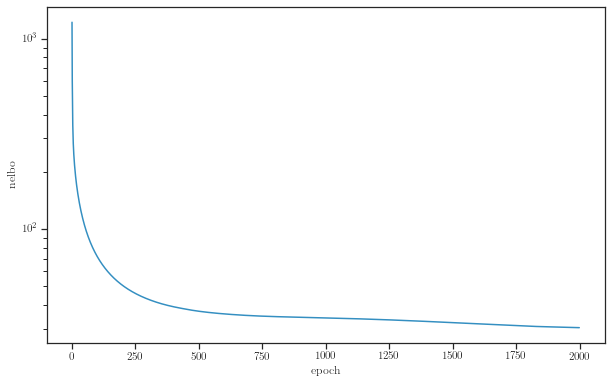

In [36]:
fig, ax = plt.subplots()

sns.lineplot(x='index', y='nelbo', data=history_df.reset_index(),
             alpha=0.8, ax=ax)

ax.set_xlabel("epoch")
ax.set_yscale("log")

plt.show()

In [37]:
inducing_index_points_history = np.stack(history["inducing_index_points"])
inducing_index_points_history.shape

(2000, 25, 1)

In [38]:
segments_min_history = np.dstack(np.broadcast_arrays(inducing_index_points_history, y_min))
segments_max_history = np.dstack([inducing_index_points_history, 
                                  history["variational_inducing_observations_loc"]])

In [39]:
segments_history = np.stack([segments_max_history, segments_min_history], axis=-2)
segments_history.shape

(2000, 25, 2, 2)

In [40]:
kernel_history = kernel_cls(amplitude=history.get("amplitude"), length_scale=history.get("length_scale"))

vgp_history = tfd.VariationalGaussianProcess(
    kernel=kernel_history,
    index_points=X_q,
    inducing_index_points=np.stack(history.get("inducing_index_points")),
    variational_inducing_observations_loc=np.stack(history.get("variational_inducing_observations_loc")),
    variational_inducing_observations_scale=np.stack(history.get("variational_inducing_observations_scale")),
    observation_noise_variance=history.get("observation_noise_variance")
)
vgp_mean = vgp_history.mean()
vgp_stddev = vgp_history.stddev()

In [41]:
with tf.Session() as sess:
    vgp_mean_value, vgp_stddev_value = sess.run([vgp_mean, vgp_stddev])

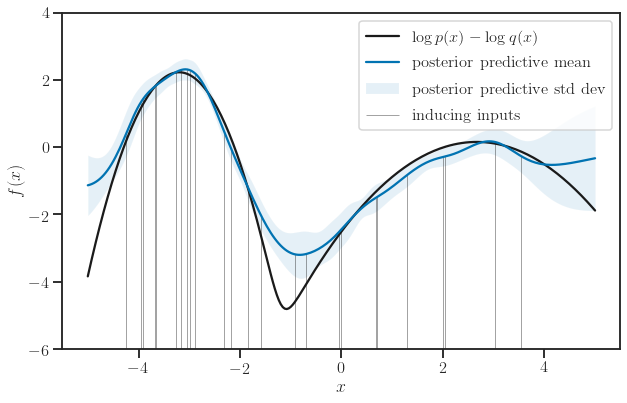

In [99]:
fig, ax = plt.subplots()

ax.plot(X_q, latent_true, 'k-', label=r"$\log p(x) - \log q(x)$")

ax.plot(X_q, vgp_mean_value[-1], label="posterior predictive mean")
ax.fill_between(np.squeeze(X_q), 
                vgp_mean_value[-1] - vgp_stddev_value[-1], 
                vgp_mean_value[-1] + vgp_stddev_value[-1], 
                alpha=0.1, label="posterior predictive std dev")

# ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.vlines(history["inducing_index_points"][-1], ymin=y_min, 
          ymax=history["variational_inducing_observations_loc"][-1],
          color='k', linewidth=1.0, alpha=0.4, label="inducing inputs")

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_ylim(y_min, y_max)

ax.legend()
fig.savefig("f_posterior_predictive.pgf")
# plt.show()

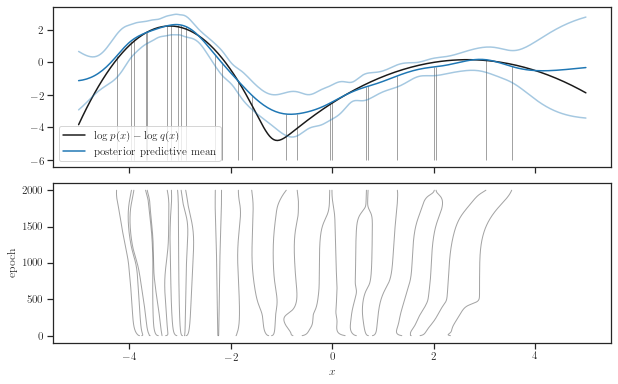

In [43]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw=dict(hspace=0.1))

ax1.plot(X_q, latent_true, 'k-', label=r"$\log p(x) - \log q(x)$")

line_mean, = ax1.plot(X_q, vgp_mean_value[-1], color="tab:blue", label="posterior predictive mean")
line_stddev_lower, = ax1.plot(X_q, vgp_mean_value[-1] - 2*vgp_stddev_value[-1], 
                              color="tab:blue", alpha=0.4)
line_stddev_upper, = ax1.plot(X_q, vgp_mean_value[-1] + 2*vgp_stddev_value[-1],
                              color="tab:blue", alpha=0.4)

vlines_inducing_index_points = ax1.vlines(inducing_index_points_history[-1].squeeze(), 
                                          ymax=history["variational_inducing_observations_loc"][-1],
                                          ymin=y_min, linewidth=1.0, alpha=0.4)

ax.set_ylabel('$f(x)$')
ax.set_ylim(y_min, y_max)

lines_inducing_index_points = ax2.plot(inducing_index_points_history.squeeze(), range(n_epochs),
                                       color='k', linewidth=1.0, alpha=0.4)

ax2.set_xlabel(r"$x$")
ax2.set_ylabel("epoch")

ax1.legend()

plt.show()

In [44]:
# num_frames = 100
num_frames = n_epochs

In [45]:
def animate(i):

    line_mean.set_data(X_q, vgp_mean_value[-num_frames+i])
    line_stddev_lower.set_data(X_q, vgp_mean_value[-num_frames+i] - 2*vgp_stddev_value[-num_frames+i])
    line_stddev_upper.set_data(X_q, vgp_mean_value[-num_frames+i] + 2*vgp_stddev_value[-num_frames+i])

    vlines_inducing_index_points.set_segments(segments_history[-num_frames+i])

    for j, line in enumerate(lines_inducing_index_points):
        line.set_data(inducing_index_points_history[:-num_frames+i, j], 
                      np.arange(n_epochs-num_frames+i))

    ax2.relim()
    ax2.autoscale_view(scalex=False)

    return lines_inducing_index_points + [line_mean, line_stddev_lower, line_stddev_upper]

In [46]:
anim = animation.FuncAnimation(fig, animate, frames=num_frames,
                               interval=60, repeat_delay=5, blit=True)

In [47]:
# HTML(anim.to_html5_video())

In [48]:
kernel_final = kernel_cls(amplitude=history["amplitude"][-1], length_scale=history["length_scale"][-1])

vgp_final = tfd.VariationalGaussianProcess(
    kernel=kernel_final,
    index_points=X_q,
    inducing_index_points=history["inducing_index_points"][-1],
    variational_inducing_observations_loc=history["variational_inducing_observations_loc"][-1],
    variational_inducing_observations_scale=history["variational_inducing_observations_scale"][-1],
    observation_noise_variance=history["observation_noise_variance"][-1]
)

In [59]:
p = tfd.LogNormal(loc=vgp_final.mean(), scale=vgp_final.stddev())
p

<tfp.distributions.LogNormal 'LogNormal' batch_shape=[256] event_shape=[] dtype=float64>

In [60]:
Y_q = np.linspace(-6, 4, 200).reshape(-1, 1)
Y_q.shape

(200, 1)

In [61]:
a = tf.exp(p.log_prob(Y_q))

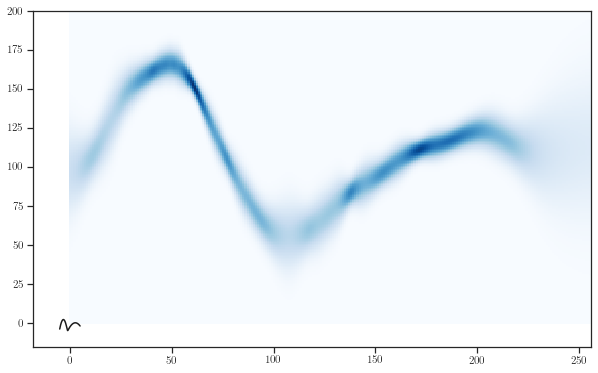

In [52]:
fig, ax = plt.subplots()

ax.plot(X_q, latent_true, 'k-', label=r"$\log p(x) - \log q(x)$")

with tf.Session() as sess:
    
#     sess.run(tf.global_variables_initializer())

    ax.pcolor(sess.run(a), cmap="Blues")

plt.show()

In [63]:
mean, stddev = p.mean(), p.stddev()

In [64]:
with tf.Session() as sess:
    mean_value, stddev_value = sess.run([mean, stddev])

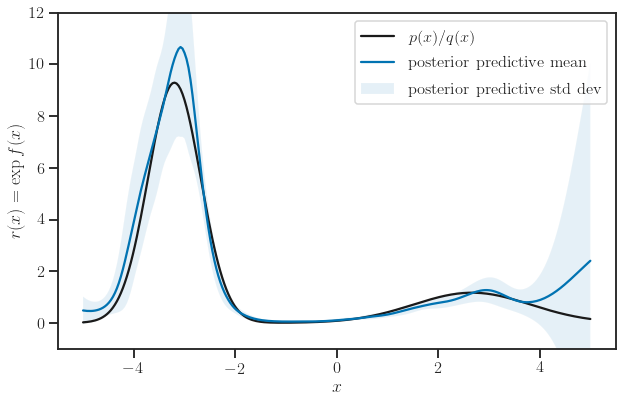

In [109]:
fig, ax = plt.subplots()

ax.plot(X_q, density_ratio_value, 'k-', label=r"$p(x) / q(x)$")

ax.plot(X_q, mean_value, label="posterior predictive mean")
ax.fill_between(np.squeeze(X_q), 
                mean_value - stddev_value, 
                mean_value + stddev_value, 
                alpha=0.1, label="posterior predictive std dev")

# ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.set_xlabel('$x$')
ax.set_ylabel('$r(x) = \exp{f(x)}$')
ax.set_ylim(-1.0, 12.0)

ax.legend()
fig.savefig("r_posterior_predictive.pgf")
# plt.show()

In [53]:
vgp_sample = vgp_final.sample(sample_shape=n_samples)
vgp_sample

<tf.Tensor 'VariationalGaussianProcess_2_3/sample/Reshape:0' shape=(20, 256) dtype=float64>

In [54]:
make_likelihood(vgp_sample).mean()

<tf.Tensor 'IndependentBernoulli_1/mean/Bernoulli/mean/Sigmoid:0' shape=(20, 256) dtype=float64>

In [55]:
with tf.Session() as sess:
    vgp_sample_value, class_prob_sample_value = sess.run([vgp_sample, make_likelihood(vgp_sample).mean()])

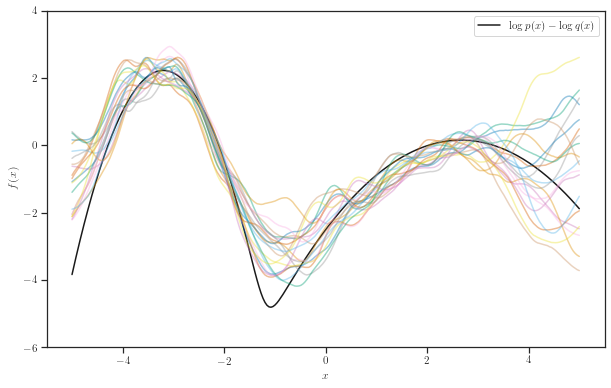

In [56]:
fig, ax = plt.subplots()

ax.plot(X_q, latent_true, 'k-', label=r"$\log p(x) - \log q(x)$")
ax.plot(X_q, vgp_sample_value.T, alpha=0.4)
# ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_ylim(y_min, y_max)

ax.legend()

plt.show()

In [57]:
names = ["sample", "x"]
v = [list(map(r"$s={}$".format, range(n_samples))), X_q.squeeze()]

index = pd.MultiIndex.from_product(v, names=names)
d = pd.DataFrame(class_prob_sample_value.ravel(), index=index, columns=["y"])
data = d.reset_index()
data

,sample,x,y
0,$s=0$,-5.000000,0.252982
1,$s=0$,-4.960784,0.261660
2,$s=0$,-4.921569,0.271282
3,$s=0$,-4.882353,0.281250
4,$s=0$,-4.843137,0.290250
...,...,...,...
5115,$s=19$,4.843137,0.123590
5116,$s=19$,4.882353,0.136051
5117,$s=19$,4.921569,0.150926
5118,$s=19$,4.960784,0.165736


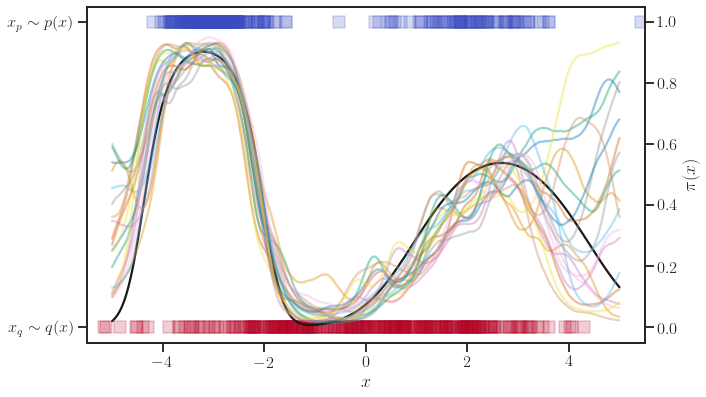

In [107]:
fig, ax1 = plt.subplots()

ax1.scatter(X, Y, c=Y, s=12.**2, 
            marker='s', alpha=.2, cmap='coolwarm_r')

ax1.set_xlabel('$x$')
ax1.set_xlim(-5.5, 5.5)

ax1.set_ylim(-0.05, 1.05)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['$x_q \sim q(x)$', 
                     '$x_p \sim p(x)$'])

ax2 = ax1.twinx()

ax2.plot(X_q, class_prob_true, 'k-')
ax2.plot(X_q, class_prob_sample_value.T, alpha=0.4)
# sns.lineplot(x='x', y='y', hue='sample', data=data, palette="tab20", alpha=0.4, ax=ax2)

ax2.set_xlim(-5.5, 5.5)
ax2.set_xlabel('$x$')

ax2.set_ylim(-0.05, 1.05)
# ax2.set_ylabel('$\mathcal{P}(y=1 \mid x)$')
ax2.set_ylabel('$\pi(x)$')
fig.savefig("pi_posterior_predictive_samples.pgf")

# plt.show()